### Importing Required Libraries

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import seaborn as sns
import random
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import Precision, Recall ,CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
import json


C:\Users\monaa\AppData\Local\Temp\ipykernel_18196\2646008476.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


### Visualizing a Sample Image

In [6]:
img = cv2.imread(os.path.join('/kaggle/input/finaldataset/FinalDataset/train/King Thutmose III/006.jpg'))

In [7]:
type(img)

numpy.ndarray

In [8]:
img.shape

(490, 349, 3)

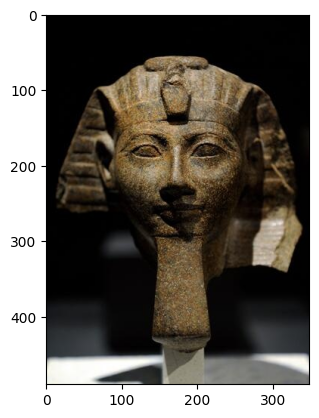

In [9]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

### Data Configuration

In [10]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
image_size = (IMG_HEIGHT, IMG_WIDTH)
batch_size = 32

In [11]:
train_data_dir='/kaggle/input/finaldataset/FinalDataset/train'
validation_data_dir='/kaggle/input/finaldataset/FinalDataset/val'

In [ ]:
class_labels = [
    'Akhenaten','AmenhotepIII',' Bent pyramid for senefru','Colossoi of Memnon',
    'Goddess Isis','Hatshepsut face','Khafre Pyramid','King Thutmose III',
    'Mask of Tutankhamun','Nefertiti','Pyramid_of_Djoser','Ramesses II',
    'Ramessum','Statur of King Zoser','Statue of Tutankhamun with Ankhesenamun',
    'Temple_of_Hatshepsut','Temple_of_Isis_in_Philae','Temple_of_Kom_Ombo',
    'The Great Temple of Ramesses II','menkaure pyramid','sphinx'
]

### Data Augmentation and Loading

In [12]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=20,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                	shear_range=0.1,
					zoom_range=0.2,
					horizontal_flip=True,
					fill_mode='nearest')

In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='rgb',
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

Found 14159 images belonging to 21 classes.


In [15]:
validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='rgb',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)


Found 4062 images belonging to 21 classes.


### Displaying Sample Images with Class Labels


In [17]:
img, label = train_generator.__next__()

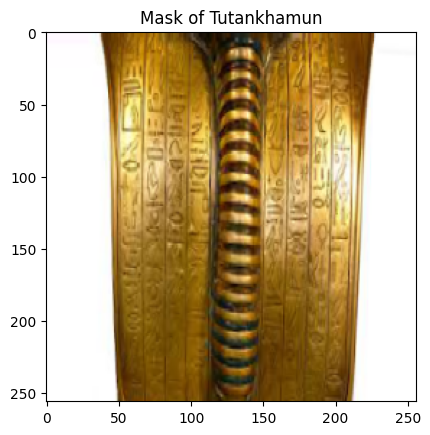

In [18]:
i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image)
plt.title(labl)
plt.show()

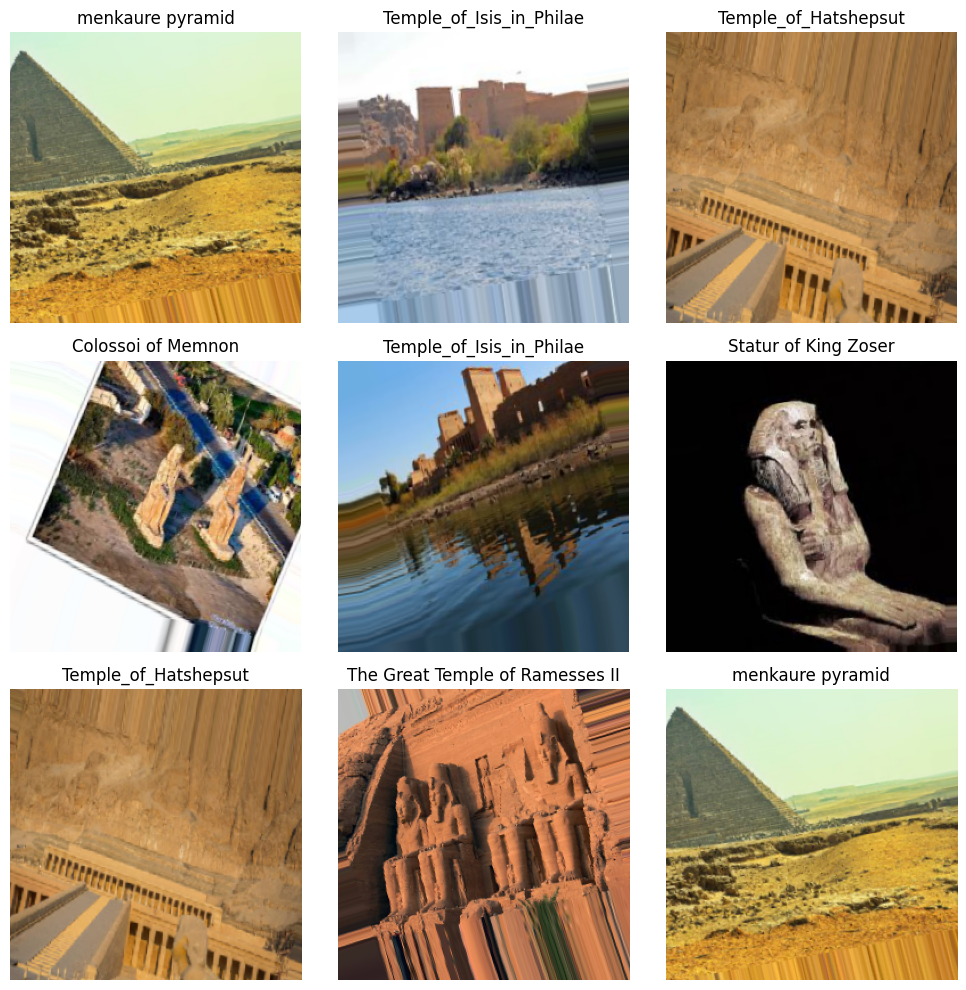

In [ ]:
np.random.seed(42) 
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
random_indices = np.random.randint(0, img.shape[0], size=9)

for i, ax in enumerate(axes.flat):
    image = img[random_indices[i]]
    labl = class_labels[label[random_indices[i]].argmax()]
    
    if image.shape[-1] == 3:
        ax.imshow(image)
    else:
        ax.imshow(image[:,:,0], cmap='gray')
    
    ax.set_title(labl)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Building and Compiling the CNN Model

In [23]:
model = Sequential()

In [ ]:
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(256,256,3)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(21, activation='softmax'))

In [25]:
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 252, 252, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │     117,965,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21)                  │          10,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,364,501 (451.52 MB)

 Trainable params: 118,364,501 (451.52 MB)

 Non-trainable params: 0 (0.00 B)

None


### Model Training with Callbacks and Final Export

In [ ]:
checkpoint = ModelCheckpoint(
    'best_pharo_model_loss.keras',           
    monitor='val_loss',       
    save_best_only=True,        
    mode='min',                 
    verbose=1
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.5,           
    patience=5,           
    min_lr=1e-6,       
    verbose=1
)

In [30]:
train_path = "/kaggle/input/finaldataset/FinalDataset/train"
test_path = "/kaggle/input/finaldataset/FinalDataset/test"

In [31]:
epochs=75


In [ ]:
history=model.fit(train_generator,
                epochs=epochs,
                validation_data=validation_generator,
                callbacks=[checkpoint,reduce_lr])


Epoch 1/75


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746991514.858765     141 service.cc:148] XLA service 0x7f26a000b5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746991514.860775     141 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746991514.860799     141 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746991515.298235     141 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/443 ━━━━━━━━━━━━━━━━━━━━ 3:28:53 28s/step - accuracy: 0.0625 - loss: 3.0406

I0000 00:00:1746991532.538394     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2276 - loss: 2.5001
Epoch 1: val_loss improved from inf to 1.77648, saving model to best_pharo_model_loss.keras

Epoch 1: val_accuracy improved from -inf to 0.46603, saving model to best_model_acc.keras
443/443 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.2277 - loss: 2.4995 - val_accuracy: 0.4660 - val_loss: 1.7765 - learning_rate: 1.0000e-04
Epoch 2/75
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.4228 - loss: 1.8260
Epoch 2: val_loss improved from 1.77648 to 1.43323, saving model to best_pharo_model_loss.keras

Epoch 2: val_accuracy improved from 0.46603 to 0.55958, saving model to best_model_acc.keras
443/443 ━━━━━━━━━━━━━━━━━━━━ 371s 823ms/step - accuracy: 0.4228 - loss: 1.8258 - val_accuracy: 0.5596 - val_loss: 1.4332 - learning_rate: 1.0000e-04
Epoch 3/75
443/443 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5286 - loss: 1.4977
Epoch 3: val_loss improved from 1.43323 to 1.30698, saving model to best_pharo_mod

KeyboardInterrupt: 

In [33]:
model.save('/kaggle/working/brave_pharos_detection_model256.keras')

### Evaluate on a Batch from Validation Set

In [34]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


In [ ]:
#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Accuracy =  1.0


### Prepare the Test Data Generator

In [7]:
test_data_dir='D:/Graduation_Project/FinalDataset/test'

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,                    
    target_size=(256, 256),     
    batch_size=32,              
    class_mode='categorical',    
    shuffle=False 
)


Found 2035 images belonging to 21 classes.


In [ ]:
test_generator.reset()

### Load Final Model and Predict on Entire Test Set

In [11]:
my_model=load_model('D:/Graduation_Project/Neural_Project/brave_pharos_detection_model256.keras')

In [12]:
# توقعات الموديل على كل test set
predictions = my_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)


e:\Program Files\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step


In [13]:
true_classes = test_generator.classes

In [14]:
accuracy = accuracy_score(true_classes, predicted_classes)
print("✅ Final Test Accuracy =", accuracy)

✅ Final Test Accuracy = 0.9557739557739557


### Plot Confusion Matrix for All Classes

📋 Classification Report:

                                         precision    recall  f1-score   support

                              Akhenaten       0.95      0.96      0.95        96
                           AmenhotepIII       0.85      0.91      0.88        96
               Bent pyramid for senefru       0.94      0.87      0.90        97
                     Colossoi of Memnon       0.91      0.88      0.89        97
                           Goddess Isis       0.99      0.96      0.97        98
                        Hatshepsut face       1.00      1.00      1.00        96
                         Khafre Pyramid       0.88      1.00      0.94        98
                      King Thutmose III       0.95      0.94      0.94        97
                    Mask of Tutankhamun       1.00      0.99      0.99        98
                              Nefertiti       0.94      0.95      0.94        96
                      Pyramid_of_Djoser       1.00      0.93      0.96        97
 

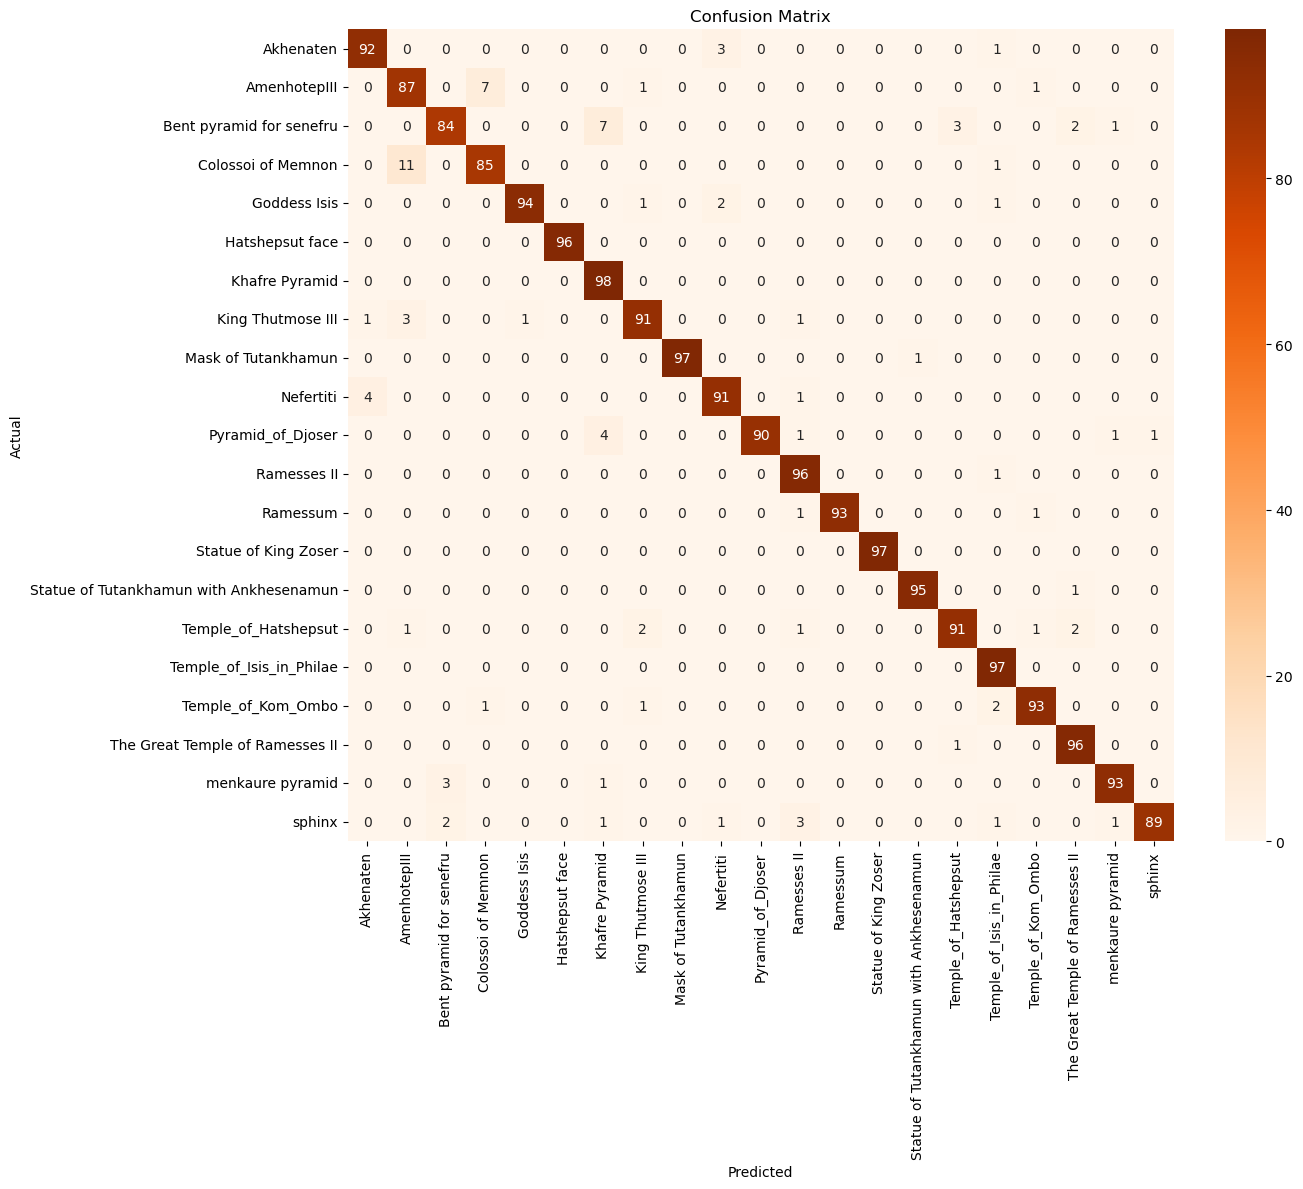

In [15]:
class_names = list(test_generator.class_indices.keys())
print("📋 Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Predict on a Single Image and Display Historical Info

In [ ]:
img_path = 'FinalDataset/test/Akhenaten/204.jpg'
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

In [ ]:
with open('class_info.json', 'r', encoding='utf-8') as f:
    class_info = json.load(f)

In [ ]:
predictions = my_model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [ ]:
predicted_class_name = class_labels[predicted_class_index]
info = class_info.get(predicted_class_name, "No Information Available For This Class")

In [ ]:
print(f"\n📸 The Predicted Class: {predicted_class_name}")
print(f"\n📜 Historic Information: \n{info}")


📸 The Predicted Class: Akhenaten

📜 Historic Information: 
Akhenaten was a pharaoh of the Eighteenth Dynasty of Egypt who ruled for 17 years. He is known for abandoning traditional Egyptian polytheism and introducing worship centered on Aten, the sun disk. His reign is marked by a dramatic shift in art and culture, often referred to as the Amarna Period.
